In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [4]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [5]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 38, 'n_layers': 2, 'dropout': 0.08362845598146633}


In [6]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [7]:
cdm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, scale_targets=True)
cdm.setup()
target_scaler = cdm.target_scaler

In [8]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, target_scaler=target_scaler):
        super(SimpleNN, self).__init__()
        self.target_scaler = target_scaler
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=8
)

In [9]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        70,331
│    └─Sequential: 2-1                   [1, 38]                   --
│    │    └─Linear: 3-1                  [1, 121]                  (24,684)
│    │    └─ReLU: 3-2                    [1, 121]                  --
│    │    └─Dropout: 3-3                 [1, 121]                  --
│    │    └─Linear: 3-4                  [1, 39]                   (4,758)
│    │    └─ReLU: 3-5                    [1, 39]                   --
│    │    └─Dropout: 3-6                 [1, 39]                   --
│    │    └─Linear: 3-7                  [1, 38]                   (1,520)
├─SimpleNN: 1-2                          [1, 1]                    --
│    └─Sequential: 2-2                   [1, 1]                    --
│    │    └─Linear: 3-8                  [1, 76]                 

In [10]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(
        cancer_autoencoder,
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=3,
            dropout=.3,
            activation=nn.LeakyReLU,
        ),
        lr=0.003,
        weight_decay=0.004,
        optimizer=torch.optim.Adam,
    )
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 6.9 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5482172966003418     │
│         test_mse          │    0.5482172966003418     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5482172966003418, 'test_mse': 0.5482172966003418}]

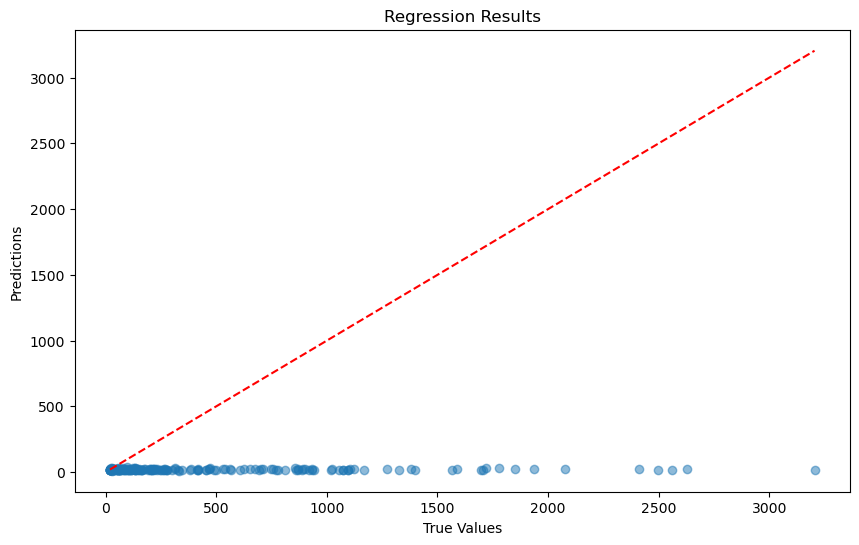

In [27]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = torch.tensor(model.neural_network.target_scaler.inverse_transform(model(x).numpy()))
            y_true.append(torch.tensor(model.neural_network.target_scaler.inverse_transform(y.numpy())))
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [13]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model = BaseCancerRegressor(
        CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
            target_scaler=target_scaler,
        ),
        lr=learning_rate,
        weight_decay=weight_decay,
        optimizer=optimizer,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [14]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="ae_regressor_scaled_study")
study.optimize(objective, n_trials=75, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-17 18:31:47,219] A new study created in memory with name: ae_regressor_scaled_study


  0%|          | 0/75 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 29.9 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
29.9 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

[I 2025-04-17 18:31:56,379] Trial 0 finished with value: 0.8468268513679504 and parameters: {'n_layers': 4, 'dropout': 0.12186590897757826, 'learning_rate': 1.597392827335869e-05, 'weight_decay': 9.246570098634937e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 0 with value: 0.8468268513679504.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:32:08,777] Trial 1 finished with value: 0.8434698581695557 and parameters: {'n_layers': 5, 'dropout': 0.19570195394281809, 'learning_rate': 0.0017146319878514002, 'weight_decay': 0.0005592455187635111, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 1 with value: 0.8434698581695557.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
598 K     Total params
2.393     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:32:15,126] Trial 2 finished with value: 0.9150470495224 and parameters: {'n_layers': 9, 'dropout': 0.05652993557682523, 'learning_rate': 2.8057623424410856e-05, 'weight_decay': 0.0008872297789488446, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 1 with value: 0.8434698581695557.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 30.7 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
30.7 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.528     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------

[I 2025-04-17 18:32:24,741] Trial 3 finished with value: 0.8457828760147095 and parameters: {'n_layers': 5, 'dropout': 0.3216542711492438, 'learning_rate': 0.00026339949483910447, 'weight_decay': 6.64008804602579e-05, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 1 with value: 0.8434698581695557.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-04-17 18:32:28,649] Trial 4 finished with value: 0.8402627110481262 and parameters: {'n_layers': 3, 'dropout': 0.2820815883044714, 'learning_rate': 0.00023614908533215002, 'weight_decay': 0.0003363143234626674, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 4 with value: 0.8402627110481262.



  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-04-17 18:32:33,577] Trial 5 finished with value: 0.8197137713432312 and parameters: {'n_layers': 12, 'dropout': 0.49691961916159094, 'learning_rate': 5.888641331994322e-05, 'weight_decay': 0.00011944102753358638, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 5 with value: 0.8197137713432312.



  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.032    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:32:38,702] Trial 6 finished with value: 0.84788978099823 and parameters: {'n_layers': 13, 'dropout': 0.061668761484670875, 'learning_rate': 0.00339016148415867, 'weight_decay': 0.00012680998080639725, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 5 with value: 0.8197137713432312.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:32:46,297] Trial 7 finished with value: 0.814358115196228 and parameters: {'n_layers': 12, 'dropout': 0.39812360483139936, 'learning_rate': 0.0004222499895658271, 'weight_decay': 2.0231228724071228e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 7 with value: 0.814358115196228.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:32:56,481] Trial 8 finished with value: 0.8907113075256348 and parameters: {'n_layers': 11, 'dropout': 0.003760557654225394, 'learning_rate': 1.9717463081896073e-05, 'weight_decay': 0.0023608847007248884, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 7 with value: 0.814358115196228.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 31.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
31.6 M    Trainable params
101 K     Non-trainable params
31.7 M    Total params
126.750   Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:33:06,778] Trial 9 finished with value: 0.8469975590705872 and parameters: {'n_layers': 14, 'dropout': 0.3714357959367595, 'learning_rate': 2.0723009646801663e-05, 'weight_decay': 0.0005736264976822559, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 7 with value: 0.814358115196228.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
597 K     Total params
2.390     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:33:17,721] Trial 10 finished with value: 0.8197913765907288 and parameters: {'n_layers': 8, 'dropout': 0.44686749649700097, 'learning_rate': 0.0009386312997774902, 'weight_decay': 1.0829959374361477e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 7 with value: 0.814358115196228.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:33:23,849] Trial 11 finished with value: 0.9494337439537048 and parameters: {'n_layers': 12, 'dropout': 0.4966526261891797, 'learning_rate': 8.977892503978462e-05, 'weight_decay': 1.3445191451103434e-05, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 7 with value: 0.814358115196228.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 31.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
31.6 M    Trainable params
101 K     Non-trainable params
31.7 M    Total params
126.753   Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:33:33,070] Trial 12 finished with value: 0.8824617266654968 and parameters: {'n_layers': 15, 'dropout': 0.4026066574570479, 'learning_rate': 8.8013299872479e-05, 'weight_decay': 2.8247726575801222e-05, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 7 with value: 0.814358115196228.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

[I 2025-04-17 18:33:39,392] Trial 13 finished with value: 0.9911040663719176 and parameters: {'n_layers': 11, 'dropout': 0.4948140860126171, 'learning_rate': 0.0005535379757059483, 'weight_decay': 0.009678913869487712, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 7 with value: 0.814358115196228.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:33:52,247] Trial 14 finished with value: 0.9021267890930176 and parameters: {'n_layers': 8, 'dropout': 0.39794393922348414, 'learning_rate': 0.008159317377543733, 'weight_decay': 3.9822121980519706e-05, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 7 with value: 0.814358115196228.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:33:59,049] Trial 15 finished with value: 0.818019688129425 and parameters: {'n_layers': 10, 'dropout': 0.33620955380241346, 'learning_rate': 7.566463034735938e-05, 'weight_decay': 0.00016984997414610983, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 7 with value: 0.814358115196228.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:34:13,194] Trial 16 finished with value: 0.8152648210525513 and parameters: {'n_layers': 10, 'dropout': 0.21894670270199396, 'learning_rate': 0.0001778292404392008, 'weight_decay': 2.7020859028636312e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 7 with value: 0.814358115196228.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 124 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
124 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:34:29,448] Trial 17 finished with value: 0.7974388599395752 and parameters: {'n_layers': 7, 'dropout': 0.21708338899691113, 'learning_rate': 0.00047007525803507115, 'weight_decay': 2.6680001046299964e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 124 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
124 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:34:36,020] Trial 18 finished with value: 0.8540664315223694 and parameters: {'n_layers': 7, 'dropout': 0.1840946623078626, 'learning_rate': 0.0005743928509175469, 'weight_decay': 1.928193798899743e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------

[I 2025-04-17 18:34:42,434] Trial 19 finished with value: 0.8145982623100281 and parameters: {'n_layers': 6, 'dropout': 0.2683309045725811, 'learning_rate': 0.002627597891073422, 'weight_decay': 4.902031809588768e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.
[I 2025-04-17 18:34:49,143] Trial 20 finished with value: 0.8997266292572021 and parameters: {'n_layers': 7, 'dropout': 0.13168145779252513, 'learning_rate': 0.0010096108756906922, 'weight_decay': 1.0707980450624352e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:35:01,579] Trial 21 finished with value: 0.8209235072135925 and parameters: {'n_layers': 6, 'dropout': 0.28341053459489435, 'learning_rate': 0.0027799654933489664, 'weight_decay': 5.2778296319713736e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:35:07,902] Trial 22 finished with value: 0.8354943990707397 and parameters: {'n_layers': 6, 'dropout': 0.2686142356270773, 'learning_rate': 0.00546451537010403, 'weight_decay': 4.896705236776589e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
597 K     Total params
2.390     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:35:19,704] Trial 23 finished with value: 0.8659605383872986 and parameters: {'n_layers': 8, 'dropout': 0.1427792124101237, 'learning_rate': 0.0004610943130017526, 'weight_decay': 2.8818433320988037e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


[I 2025-04-17 18:35:29,656] Trial 24 finished with value: 0.8247050642967224 and parameters: {'n_layers': 6, 'dropout': 0.23395493455229543, 'learning_rate': 0.00123621235011386, 'weight_decay': 1.885596763608518e-05, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 17 with value: 0.7974388599395752.


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 6.9 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
6.9 K     Trainable params
101 K     Non-trainable params
108 K     Total params
0.433     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:35:37,509] Trial 25 finished with value: 0.8436749577522278 and parameters: {'n_layers': 3, 'dropout': 0.3157869503689913, 'learning_rate': 0.0022636511297670836, 'weight_decay': 0.0002069519637671826, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
598 K     Total params
2.393     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:35:45,271] Trial 26 finished with value: 0.9363749623298644 and parameters: {'n_layers': 9, 'dropout': 0.36248219756277555, 'learning_rate': 0.00015056964659949064, 'weight_decay': 7.584465037067588e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 30.7 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
30.7 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.528     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:36:03,034] Trial 27 finished with value: 0.8431932926177979 and parameters: {'n_layers': 5, 'dropout': 0.4452986588468172, 'learning_rate': 0.00040010239362310904, 'weight_decay': 1.7893016916566194e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 124 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
124 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:36:11,478] Trial 28 finished with value: 0.8563982248306274 and parameters: {'n_layers': 7, 'dropout': 0.17413318101816594, 'learning_rate': 0.004962231659320711, 'weight_decay': 3.747395564274223e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 29.9 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
29.9 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:36:24,355] Trial 29 finished with value: 0.8782609701156616 and parameters: {'n_layers': 4, 'dropout': 0.24480948029981137, 'learning_rate': 1.101512134679771e-05, 'weight_decay': 0.00010162088098681907, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 31.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
31.6 M    Trainable params
101 K     Non-trainable params
31.7 M    Total params
126.753   Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:36:33,579] Trial 30 finished with value: 0.8325077891349792 and parameters: {'n_layers': 15, 'dropout': 0.09416763579232063, 'learning_rate': 0.0007775008133173435, 'weight_decay': 0.00023759669703073125, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:37:01,512] Trial 31 finished with value: 0.8021735548973083 and parameters: {'n_layers': 10, 'dropout': 0.22674261054275638, 'learning_rate': 0.00018695171795985154, 'weight_decay': 2.6780784689165456e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:37:49,370] Trial 32 finished with value: 0.8112843036651611 and parameters: {'n_layers': 10, 'dropout': 0.20522404712891432, 'learning_rate': 0.001606945216300278, 'weight_decay': 2.018739343834464e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:37:57,462] Trial 33 finished with value: 0.849554181098938 and parameters: {'n_layers': 10, 'dropout': 0.20548982923804374, 'learning_rate': 0.0016269735141262304, 'weight_decay': 1.7083512943016488e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:38:05,906] Trial 34 finished with value: 0.968773365020752 and parameters: {'n_layers': 12, 'dropout': 0.15674844205238772, 'learning_rate': 0.00032778195421559437, 'weight_decay': 2.5573791392121097e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
598 K     Total params
2.393     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:38:15,845] Trial 35 finished with value: 0.916717290878296 and parameters: {'n_layers': 9, 'dropout': 0.20443246049011637, 'learning_rate': 0.0001484570002587666, 'weight_decay': 7.964145769285309e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:38:24,518] Trial 36 finished with value: 0.8262156844139099 and parameters: {'n_layers': 11, 'dropout': 0.09839655712847573, 'learning_rate': 0.0002539092149140755, 'weight_decay': 0.0017758594159028146, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.032    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:38:36,901] Trial 37 finished with value: 0.8403633832931519 and parameters: {'n_layers': 13, 'dropout': 0.30246746167730176, 'learning_rate': 4.137456438383742e-05, 'weight_decay': 1.0074634844675427e-05, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:38:45,341] Trial 38 finished with value: 0.9599066972732544 and parameters: {'n_layers': 10, 'dropout': 0.16718991173309328, 'learning_rate': 0.000707947295982431, 'weight_decay': 5.862646417706636e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.032    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:39:06,034] Trial 39 finished with value: 0.8201119899749756 and parameters: {'n_layers': 13, 'dropout': 0.23588444451398616, 'learning_rate': 0.0015363274722411003, 'weight_decay': 0.00041909418241765765, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:39:22,833] Trial 40 finished with value: 0.7976418733596802 and parameters: {'n_layers': 11, 'dropout': 0.10910668247760053, 'learning_rate': 0.00021675446946152287, 'weight_decay': 1.5072045963234684e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:39:32,728] Trial 41 finished with value: 0.9469929337501526 and parameters: {'n_layers': 11, 'dropout': 0.006168366317928331, 'learning_rate': 0.00018698188776865288, 'weight_decay': 1.4744352784831805e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:39:48,642] Trial 42 finished with value: 0.8800357580184937 and parameters: {'n_layers': 12, 'dropout': 0.04376668106743292, 'learning_rate': 0.00025188062453789347, 'weight_decay': 2.3203154982155515e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:39:59,715] Trial 43 finished with value: 0.8695852756500244 and parameters: {'n_layers': 11, 'dropout': 0.09235659519984567, 'learning_rate': 0.00011415859449137646, 'weight_decay': 3.6358649856038014e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:40:10,195] Trial 44 finished with value: 0.8272355794906616 and parameters: {'n_layers': 10, 'dropout': 0.21576472529061935, 'learning_rate': 0.0003520328011447189, 'weight_decay': 1.2758895025018421e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 31.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
31.6 M    Trainable params
101 K     Non-trainable params
31.7 M    Total params
126.750   Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:40:31,263] Trial 45 finished with value: 0.901614785194397 and parameters: {'n_layers': 14, 'dropout': 0.11405710977502595, 'learning_rate': 0.00011839232049231383, 'weight_decay': 3.6172342244144305e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
598 K     Total params
2.393     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:40:48,633] Trial 46 finished with value: 0.8177762627601624 and parameters: {'n_layers': 9, 'dropout': 0.2539279183990023, 'learning_rate': 3.808231981956884e-05, 'weight_decay': 0.00013444657054279777, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
597 K     Total params
2.390     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:40:57,521] Trial 47 finished with value: 0.8210024237632751 and parameters: {'n_layers': 8, 'dropout': 0.1910543903579611, 'learning_rate': 0.000529202904322119, 'weight_decay': 0.00896504842886613, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:41:08,162] Trial 48 finished with value: 0.848608136177063 and parameters: {'n_layers': 12, 'dropout': 0.06529960332984786, 'learning_rate': 6.259756659031772e-05, 'weight_decay': 2.1659347550175678e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
598 K     Total params
2.393     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:41:17,171] Trial 49 finished with value: 0.890669047832489 and parameters: {'n_layers': 9, 'dropout': 0.3390696340900932, 'learning_rate': 0.00020206711636769695, 'weight_decay': 1.5139921713888634e-05, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:41:28,589] Trial 50 finished with value: 0.8670023679733276 and parameters: {'n_layers': 11, 'dropout': 0.15018225625415182, 'learning_rate': 0.0009874080002995232, 'weight_decay': 3.037841785968581e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:41:44,791] Trial 51 finished with value: 0.817375659942627 and parameters: {'n_layers': 10, 'dropout': 0.284617843197696, 'learning_rate': 0.003822198959268464, 'weight_decay': 4.3305700788271474e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 29.9 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
29.9 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:41:54,336] Trial 52 finished with value: 0.8399015665054321 and parameters: {'n_layers': 4, 'dropout': 0.43220936128354875, 'learning_rate': 0.0021713196326888042, 'weight_decay': 5.690414967163883e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
597 K     Total params
2.390     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:42:23,112] Trial 53 finished with value: 0.8474741578102112 and parameters: {'n_layers': 8, 'dropout': 0.26393748267303185, 'learning_rate': 0.0006604067031880192, 'weight_decay': 1.3268843326106765e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.032    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:42:33,401] Trial 54 finished with value: 0.8340393304824829 and parameters: {'n_layers': 13, 'dropout': 0.22058243341228795, 'learning_rate': 0.007290062635311168, 'weight_decay': 2.1339116427208268e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 30.7 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
30.7 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.528     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:42:46,028] Trial 55 finished with value: 0.8380778431892395 and parameters: {'n_layers': 5, 'dropout': 0.2985498437878388, 'learning_rate': 0.0013262437531012502, 'weight_decay': 3.0506925279992273e-05, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 124 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
124 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:42:58,786] Trial 56 finished with value: 0.8157047033309937 and parameters: {'n_layers': 7, 'dropout': 0.3813374749361635, 'learning_rate': 0.0029537071224192543, 'weight_decay': 2.3316946043706015e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:43:07,841] Trial 57 finished with value: 0.8195502161979675 and parameters: {'n_layers': 6, 'dropout': 0.3422183025201217, 'learning_rate': 0.00044016187373674783, 'weight_decay': 4.573011293127751e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:43:17,938] Trial 58 finished with value: 0.8317833542823792 and parameters: {'n_layers': 10, 'dropout': 0.47049403597874273, 'learning_rate': 0.00010712704605672116, 'weight_decay': 6.925053939622647e-05, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:43:31,010] Trial 59 finished with value: 0.813381552696228 and parameters: {'n_layers': 12, 'dropout': 0.41684990023119717, 'learning_rate': 0.00030389552639085255, 'weight_decay': 0.001090631873501001, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 31.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
31.6 M    Trainable params
101 K     Non-trainable params
31.7 M    Total params
126.750   Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:43:42,152] Trial 60 finished with value: 0.8602315187454224 and parameters: {'n_layers': 14, 'dropout': 0.3973139244509412, 'learning_rate': 0.0002985650816563291, 'weight_decay': 0.0008370635223879415, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:43:52,751] Trial 61 finished with value: 0.8626250624656677 and parameters: {'n_layers': 12, 'dropout': 0.42894132091397086, 'learning_rate': 0.00022006349115840144, 'weight_decay': 0.0010980710057530388, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:44:12,309] Trial 62 finished with value: 0.8132396936416626 and parameters: {'n_layers': 11, 'dropout': 0.41536430589609097, 'learning_rate': 0.00015421652384858597, 'weight_decay': 0.002246195310341241, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:44:22,667] Trial 63 finished with value: 0.8430553674697876 and parameters: {'n_layers': 11, 'dropout': 0.4282586814649816, 'learning_rate': 0.00015119558212834815, 'weight_decay': 0.004316789702291528, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:44:36,662] Trial 64 finished with value: 0.8143041729927063 and parameters: {'n_layers': 12, 'dropout': 0.41335574193669694, 'learning_rate': 0.0003669956489196321, 'weight_decay': 0.002597674039290987, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:44:48,105] Trial 65 finished with value: 0.884684681892395 and parameters: {'n_layers': 12, 'dropout': 0.4130963666006831, 'learning_rate': 0.00029320277427489816, 'weight_decay': 0.002804786854085771, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:45:01,221] Trial 66 finished with value: 0.8119835257530212 and parameters: {'n_layers': 11, 'dropout': 0.45613868735917984, 'learning_rate': 8.74404644536036e-05, 'weight_decay': 0.003811576318610079, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:45:19,394] Trial 67 finished with value: 0.83184415102005 and parameters: {'n_layers': 11, 'dropout': 0.46523528664530456, 'learning_rate': 8.734542437174715e-05, 'weight_decay': 0.004042211760172375, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:45:30,085] Trial 68 finished with value: 0.8160077929496765 and parameters: {'n_layers': 10, 'dropout': 0.4727973803956768, 'learning_rate': 5.971048239226012e-05, 'weight_decay': 0.001517610564552966, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:45:41,919] Trial 69 finished with value: 0.940332055091858 and parameters: {'n_layers': 11, 'dropout': 0.45538039374923267, 'learning_rate': 0.00014840881600431958, 'weight_decay': 0.006417477142031047, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
598 K     Total params
2.393     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:45:52,585] Trial 70 finished with value: 0.8190058469772339 and parameters: {'n_layers': 9, 'dropout': 0.35974738027942565, 'learning_rate': 3.71633337775253e-05, 'weight_decay': 0.0006644615703881235, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 17 with value: 0.7974388599395752.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.032    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:46:10,057] Trial 71 finished with value: 0.8335566520690918 and parameters: {'n_layers': 13, 'dropout': 0.38040525840965317, 'learning_rate': 0.00037103103461945424, 'weight_decay': 0.002472203857233683, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:46:21,758] Trial 72 finished with value: 0.8802885413169861 and parameters: {'n_layers': 11, 'dropout': 0.41455223145009656, 'learning_rate': 7.492205042461803e-05, 'weight_decay': 0.003344203357142663, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.032    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 18:46:44,760] Trial 73 finished with value: 0.9202769994735718 and parameters: {'n_layers': 13, 'dropout': 0.1701907896330954, 'learning_rate': 0.00012744853450561512, 'weight_decay': 0.001967114417289118, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 0.7974388599395752.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 18:47:05,521] Trial 74 finished with value: 0.8142639398574829 and parameters: {'n_layers': 12, 'dropout': 0.49984091849059314, 'learning_rate': 0.00018723277084962923, 'weight_decay': 0.005352407615684468, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 17 with value: 0.7974388599395752.
Best trial:
  Value (val_mse): 0.7974388599395752
  Params:
    n_layers: 7
    dropout: 0.21708338899691113
    learning_rate: 0.00047007525803507115
    weight_decay: 2.6680001046299964e-05
    optimizer: adagrad
    activation: leaky_relu


In [15]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

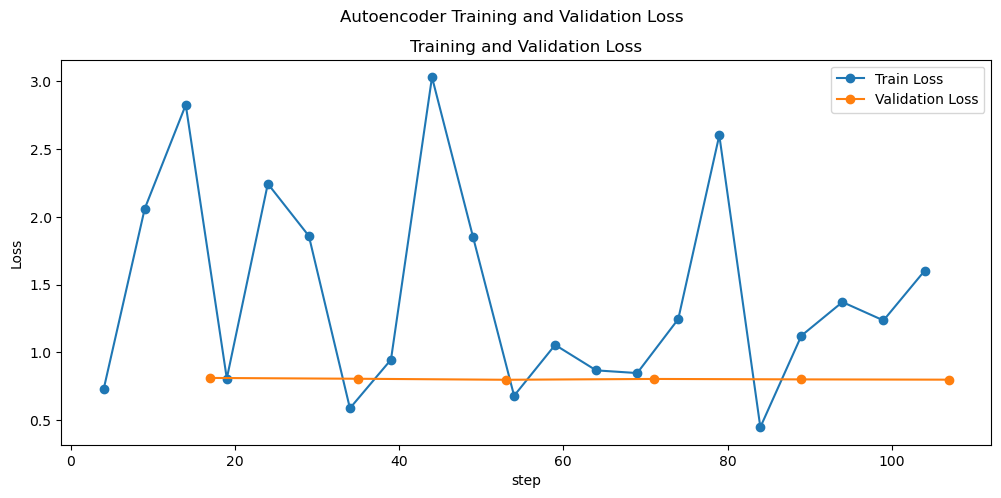

In [16]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [17]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/05/best_model.pth

In [18]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}

best_model = BaseCancerRegressor.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    auto_encoder=CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        neural_network=SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=study.best_trial.params['n_layers'],
            dropout=study.best_trial.params['dropout'],
            activation=activation_dict[study.best_trial.params['activation']],
            target_scaler=target_scaler,
        ),
        lr=study.best_trial.params['learning_rate'],
        weight_decay=study.best_trial.params['weight_decay'],
        optimizer=optimizer_dict[study.best_trial.params['optimizer']],
    
)
best_model

BaseCancerRegressor(
  (auto_encoder): CancerDataAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=203, out_features=121, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.08362845598146633, inplace=False)
      (3): Linear(in_features=121, out_features=39, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.08362845598146633, inplace=False)
      (6): Linear(in_features=39, out_features=38, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=38, out_features=120, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.08362845598146633, inplace=False)
      (3): Linear(in_features=120, out_features=202, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.08362845598146633, inplace=False)
      (6): Linear(in_features=202, out_features=203, bias=True)
    )
    (loss_metric): MeanSquaredError()
    (val_metric): MeanSquaredError()
    (test_metric): MeanSquaredError()
  )
  (neural_network): SimpleNN(
    (network): Sequential(
      (0): Linear(

In [21]:
trainer2, regressor_csv_logger2, regressor_checkpoint2 = create_classifier_trainer("cancer_regressor", max_epochs=50, allow_early_stop=False)
trainer2.fit(
    model=best_model,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 124 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
124 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


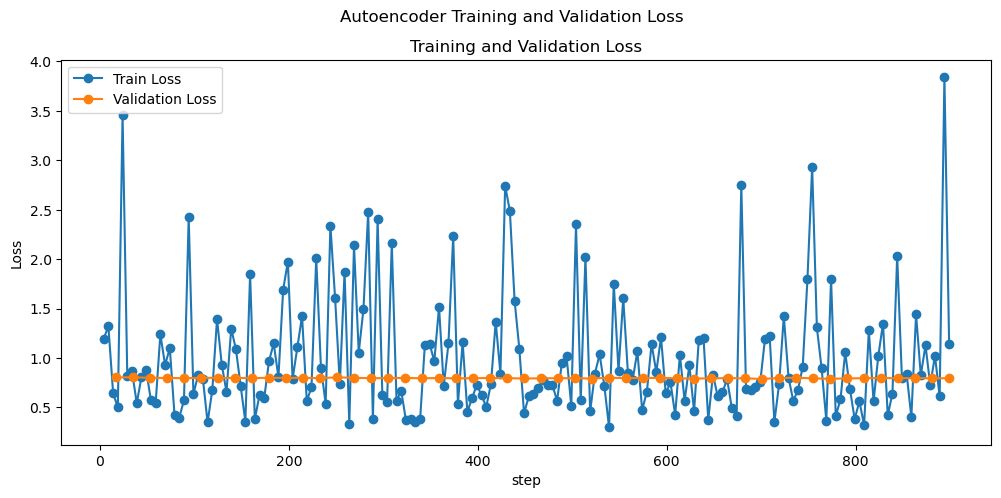

In [22]:
history = pd.read_csv(regressor_csv_logger2.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [19]:
joblib.dump(
    best_model,
    f"results/05/best_model_trial_ae_scaled_{study.best_trial.number}.pkl",
)

['results/05/best_model_trial_ae_scaled_17.pkl']

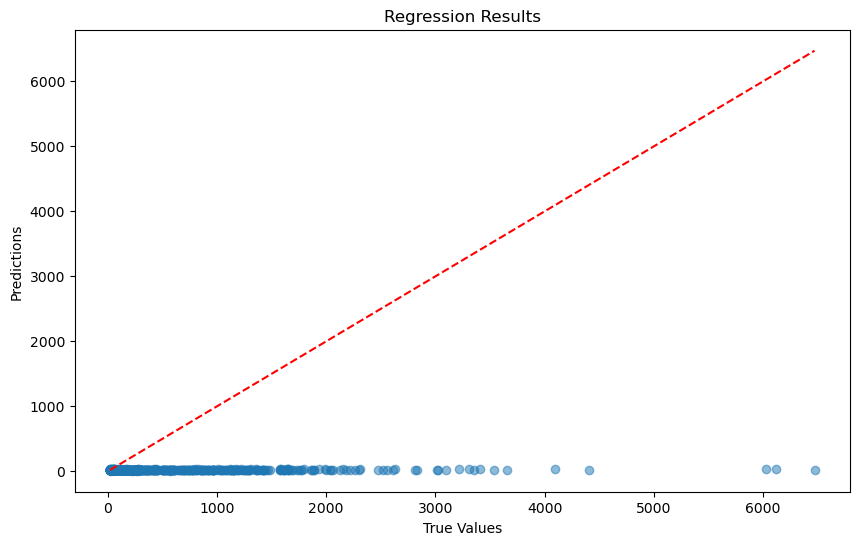

In [28]:
plot_regression_results(cancer_regressor, cancer_dm.train_dataloader())

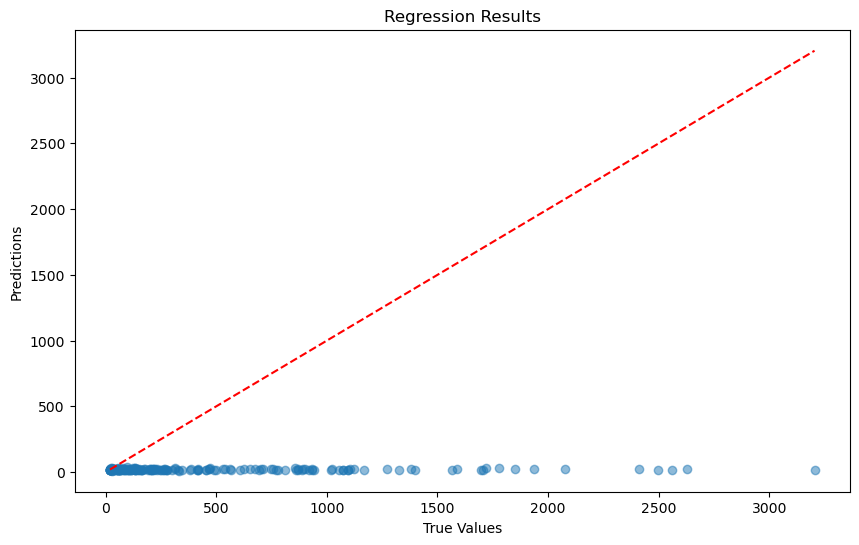

In [23]:
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())